## Imports

In [67]:
import os
import sys
import json
import importlib.util
from pathlib import Path

import numpy as np
import pandas as pd
from scipy.stats import pearsonr, linregress

from statsmodels.stats.multitest import multipletests

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LassoCV, Ridge, RidgeCV
from sklearn.model_selection import KFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.utils import shuffle

from preprocessing.wheel import wheel_to_angles
from preprocessing.prp import add_perceived_probs


## Data load

In [68]:
droot = Path('C:/Users/qf1824/Desktop/coding/Arseniis_Msc_proj/data/JPAS_0023_20230922')
dp = droot/'PHY_AK/uploaded_folder/JPAS_0023_20230922'
bp = droot/'BEHAV'

clust_qa = pd.read_csv(dp/'cluster_group.tsv', sep='\t')
clust_qa.head()

,cluster_id,group
0,0,good
1,1,good
2,2,good
3,3,good
4,4,good


Number of units in each label:

In [69]:
clust_qa.groupby('group').count()

,cluster_id
group,
good,367
mua,185
noise,23


Filter only good labeled units

In [70]:
good_unit_id = clust_qa[clust_qa.group=='good'].cluster_id.tolist()
len(good_unit_id)

367

In [71]:
spike_clusters = np.load(dp/'spike_clusters.npy')
# spike_times = np.load(dp/'spike_times.npy')
spike_times = np.load(dp/'spike_times_milliseconds_sync_to_behav.npy')
spike_times.shape, spike_clusters.shape

((8708550,), (8708550,))

In [72]:
sp = np.stack([spike_clusters, spike_times]).T
sp.shape, sp[:5, :]

((8708550, 2),
 array([[1.64000000e+02, 3.76224106e+05],
        [1.29000000e+02, 3.76225058e+05],
        [5.63000000e+02, 3.76225354e+05],
        [3.24000000e+02, 3.76225518e+05],
        [5.53000000e+02, 3.76225604e+05]]))

In [73]:
gsp = sp[np.isin(sp[:,0], good_unit_id)]
gsp.shape

(3253121, 2)

Load sampling rate to align spike sample # to experimet time

In [74]:
phy_params_path = dp/'params.py'
module_name = 'sample_rate'

spec = importlib.util.spec_from_file_location(module_name, phy_params_path)
module = importlib.util.module_from_spec(spec)
sys.modules[module_name] = module
spec.loader.exec_module(module)
SR = module.sample_rate
SR

32050.755862876373

Load behavour offset time to align to spikes

In [75]:
with open(droot/'start_time_offset.txt') as f:
    start_offset = f.readline()
start_offset = start_offset.split(', ')[1]
start_offset = float(start_offset)
print(f'behaviour offset to spikes: {start_offset} sec.')

behaviour offset to spikes: 61.88147351299333 sec.


In [76]:
with open(bp/'metrics.json') as f:
    behav = json.load(f)
metrics = behav['metrics']
trials = pd.DataFrame(metrics['trials'])
blocks = pd.DataFrame(metrics['blocks'])
states = pd.DataFrame(metrics['states'], columns=('time', 'state'))
states.sort_values(by='time', inplace=True)
wheel = np.array(behav['wheel'])
print(f'trials shape: {trials.shape}')
print(f'blocks shape: {blocks.shape}')
print(f'states shape: {states.shape}')
print(f'wheel shape: {wheel.shape}')


trials shape: (258, 11)
blocks shape: (8, 4)
states shape: (1044, 2)
wheel shape: (726867, 2)


In [77]:
wheel

array([[      0,  214462],
       [    542,  214463],
       [    551,  214464],
       ...,
       [2732625,  356608],
       [2732782,  356609],
       [2733178,  356610]], shape=(726867, 2))

In [78]:
with open(droot/'PHY_AK/arguments.json') as f:
    args = json.load(f)

if args['pr_t_min_s'] is not None:
    start_offset = args['pr_t_min_s'] - (start_offset*2)
start_offset

376.23705297401335

Correcting the behaviour time offset to align with spiking data

In [79]:
trials

,start,hold_start,t choosing,t chosen,choice,rewarded,set reward probabs l/r,Achievement reached,reward rate recent,rew rate in recent rights,rew rate in recent lefts
0,483046,483964.0,484765.0,485080.0,r,True,"[0.7837631053618482, 0.11006217680373397]",False,1.000000,1.000000,0.000000
1,486080,487305.0,488275.0,488649.0,r,False,"[0.7837631053618482, 0.11006217680373397]",False,0.500000,0.500000,0.000000
2,493650,494603.0,495854.0,495982.0,r,False,"[0.7837631053618482, 0.11006217680373397]",False,0.333333,0.333333,0.000000
3,500981,502049.0,503589.0,504336.0,l,False,"[0.7837631053618482, 0.11006217680373397]",False,0.250000,0.333333,0.000000
4,509336,510282.0,511612.0,512170.0,l,True,"[0.7837631053618482, 0.11006217680373397]",False,0.400000,0.333333,0.500000
...,...,...,...,...,...,...,...,...,...,...,...
253,1869729,1870764.0,1871585.0,1871941.0,r,False,"[0.7644747147846659, 0.10096068588514409]",False,0.000000,0.000000,0.714286
254,1876942,1878125.0,1878925.0,1879284.0,r,False,"[0.7644747147846659, 0.10096068588514409]",False,0.000000,0.000000,0.714286
255,1884284,1885352.0,1886274.0,1886609.0,r,False,"[0.7644747147846659, 0.10096068588514409]",False,0.000000,0.000000,0.714286
256,1891608,1893101.0,1893964.0,1894248.0,r,False,"[0.7644747147846659, 0.10096068588514409]",False,0.000000,0.000000,0.714286


In [80]:
# ms_offset = start_offset*1000
# trials['start'] = trials.start - ms_offset
# trials['hold_start'] = trials.hold_start - ms_offset
# trials['t choosing'] = trials['t choosing'] - ms_offset
# trials['t chosen'] = trials['t chosen'] - ms_offset
# states['time'] = states['time'] - ms_offset
# wheel[:,0] = wheel[:,0] - ms_offset


In [81]:
trials

,start,hold_start,t choosing,t chosen,choice,rewarded,set reward probabs l/r,Achievement reached,reward rate recent,rew rate in recent rights,rew rate in recent lefts
0,483046,483964.0,484765.0,485080.0,r,True,"[0.7837631053618482, 0.11006217680373397]",False,1.000000,1.000000,0.000000
1,486080,487305.0,488275.0,488649.0,r,False,"[0.7837631053618482, 0.11006217680373397]",False,0.500000,0.500000,0.000000
2,493650,494603.0,495854.0,495982.0,r,False,"[0.7837631053618482, 0.11006217680373397]",False,0.333333,0.333333,0.000000
3,500981,502049.0,503589.0,504336.0,l,False,"[0.7837631053618482, 0.11006217680373397]",False,0.250000,0.333333,0.000000
4,509336,510282.0,511612.0,512170.0,l,True,"[0.7837631053618482, 0.11006217680373397]",False,0.400000,0.333333,0.500000
...,...,...,...,...,...,...,...,...,...,...,...
253,1869729,1870764.0,1871585.0,1871941.0,r,False,"[0.7644747147846659, 0.10096068588514409]",False,0.000000,0.000000,0.714286
254,1876942,1878125.0,1878925.0,1879284.0,r,False,"[0.7644747147846659, 0.10096068588514409]",False,0.000000,0.000000,0.714286
255,1884284,1885352.0,1886274.0,1886609.0,r,False,"[0.7644747147846659, 0.10096068588514409]",False,0.000000,0.000000,0.714286
256,1891608,1893101.0,1893964.0,1894248.0,r,False,"[0.7644747147846659, 0.10096068588514409]",False,0.000000,0.000000,0.714286


In [82]:
states

,time,state
0,0,delay
2,53182,waiting
3,113180,waiting
4,173179,waiting
5,233180,waiting
...,...,...
1040,2504738,waiting
1041,2564738,waiting
1042,2624692,waiting
1043,2684738,waiting


In [83]:
time_0_trials = trials.start.values
print(f'first-last trial at: {time_0_trials[0]/(60*1000):.2f} - {time_0_trials[-1]/(60*1000):.2f} min.')
print(f'first-last spike at: {gsp[0, 1]/(60*1000):.2f} - {gsp[-1, 1]/(60*1000):.2f} min.')
print(f'first-last wheel at: {wheel[0,0]/(60*1000):.2f} - {wheel[-1,0]/(60*1000):.2f} min.')
print(f'first-last states at: {states.time.min()/(60*1000):.2f} - {states.time.max()/(60*1000):.2f} min.')

first-last trial at: 8.05 - 31.65 min.
first-last spike at: 6.27 - 29.60 min.
first-last wheel at: 0.00 - 45.55 min.
first-last states at: 0.00 - 75.29 min.


Check for gaps in wheel log

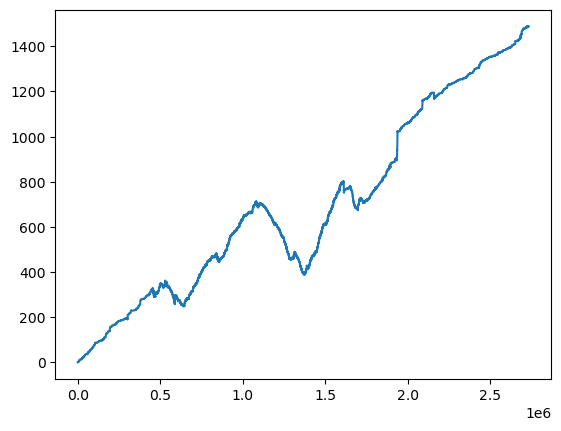

In [84]:
TICKS_PER_REV = 600

angles = wheel_to_angles(wheel[:,1], unwrap=True, ticks_per_rev=TICKS_PER_REV)

plt.plot(wheel[:,0], angles)

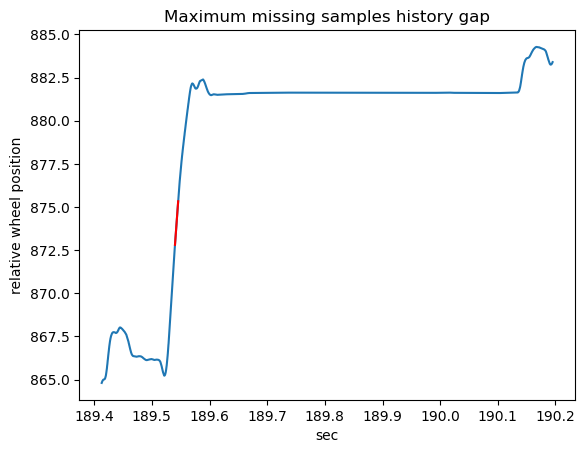

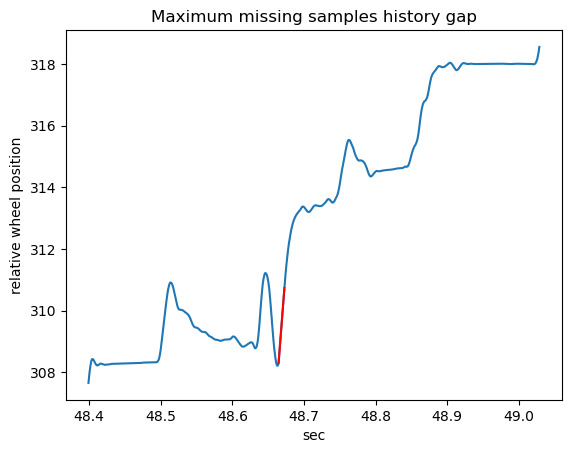

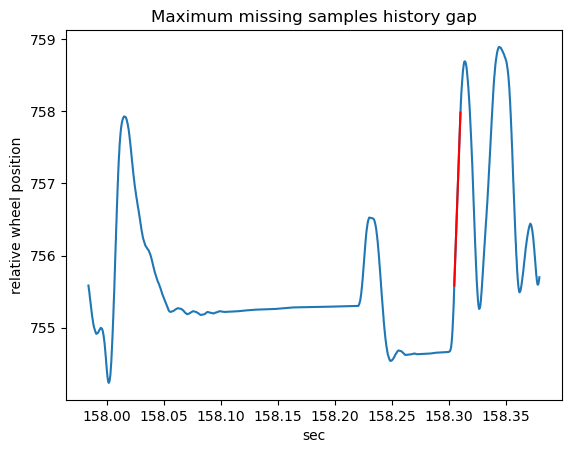

In [85]:
gap_idxs = np.argsort(np.abs(np.diff(angles)))
for gap_idx in gap_idxs[::-1][:3]:
	take_samples = 1000
	take_from = gap_idx - take_samples
	take_to = gap_idx + take_samples
	plt.plot(wheel[take_from: take_to, 0]/(1e4), angles[take_from: take_to], label='')
	plt.plot(wheel[gap_idx: gap_idx+2, 0]/(1e4), angles[gap_idx: gap_idx+2], c='red', label='gap')
	plt.xlabel('sec')
	plt.ylabel('relative wheel position')
	plt.title('Maximum missing samples history gap')
	plt.show()

Conclusion: wheel data gaps is moderate and can be linearly interpolated no need for fitting polynomial!

Computing Perceived Reward Probabilities

In [86]:
INIT_PRP = 0.5
# INIT_PRP = np.nan
trials = add_perceived_probs(trials, init_p=INIT_PRP)
trials[27:30]

,start,hold_start,t choosing,t chosen,choice,rewarded,set reward probabs l/r,Achievement reached,reward rate recent,rew rate in recent rights,rew rate in recent lefts,PRPr,PRPl,PRPD,RR_rate
27,634849,636089.0,637081.0,637189.0,l,False,"[0.7837631053618482, 0.11006217680373397]",False,0.642857,0.166667,0.714286,0.5,0.6,-0.1,0.1
28,642188,NaN,NaN,NaN,nan,True,NaN,True,0.571429,0.166667,0.714286,0.5,0.6,-0.1,0.0
29,642188,643480.0,644890.0,645157.0,l,True,"[0.11006217680373397, 0.7837631053618482]",False,0.571429,0.166667,0.714286,0.5,0.6,-0.1,0.0


Perceived Reward Probabilities Visualisation

In [87]:
trials[trials['set reward probabs l/r'].isna()]

,start,hold_start,t choosing,t chosen,choice,rewarded,set reward probabs l/r,Achievement reached,reward rate recent,rew rate in recent rights,rew rate in recent lefts,PRPr,PRPl,PRPD,RR_rate
28,642188,NaN,NaN,NaN,nan,True,NaN,True,0.571429,0.166667,0.714286,0.5,0.6,-0.1,0.0
93,959968,NaN,NaN,NaN,nan,True,NaN,True,0.714286,0.714286,0.214286,0.8,0.2,0.6,0.9
168,1366317,NaN,NaN,NaN,nan,True,NaN,True,0.785714,0.071429,0.785714,0.0,0.9,-0.9,0.0
212,1595641,NaN,NaN,NaN,nan,True,NaN,True,0.714286,0.785714,0.642857,0.7,0.5,0.2,0.9


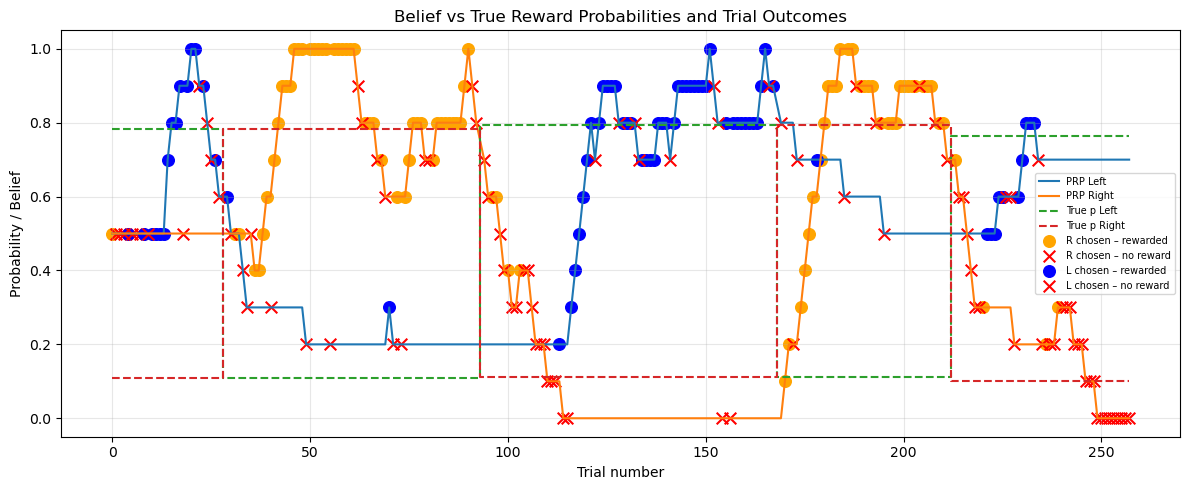

In [88]:
plt.close()
trls = trials[~trials['set reward probabs l/r'].isna()].copy()

true_prob = np.array(trls['set reward probabs l/r'].tolist())
trls['true_pL'], trls['true_pR'] = true_prob[:, 0], true_prob[:, 1]

# summary plot
fig, ax = plt.subplots(figsize=(12, 5))

# perceived reward probabilities (belief)
ax.plot(trls.index, trls['PRPl'], label='PRP Left')
ax.plot(trls.index, trls['PRPr'], label='PRP Right')

# true reward probabilities
ax.step(trls.index, trls['true_pL'], linestyle='--', where='mid',
        label='True p Left')
ax.step(trls.index, trls['true_pR'], linestyle='--', where='mid',
        label='True p Right')

# choice outcomes
right = trls['choice'].str.lower().eq('r')
left = trls['choice'].str.lower().eq('l')

ax.scatter(trls.index[right & trls['rewarded']],
           trls.loc[right & trls['rewarded'], 'PRPr'],
           marker='o', s=70, c='orange', label='R chosen – rewarded')
ax.scatter(trls.index[right & ~trls['rewarded']],
           trls.loc[right & ~trls['rewarded'], 'PRPr'],
           marker='x', s=70, c='r', label='R chosen – no reward')

ax.scatter(trls.index[left & trls['rewarded']],
           trls.loc[left & trls['rewarded'], 'PRPl'],
           marker='o', s=70, c='blue', label='L chosen – rewarded')

ax.scatter(trls.index[left & ~trls['rewarded']],
           trls.loc[left & ~trls['rewarded'], 'PRPl'],
           marker='x', s=70, c='r', label='L chosen – no reward')

ax.set_xlabel('Trial number')
ax.set_ylabel('Probability / Belief')
ax.set_ylim(-0.05, 1.05)
ax.set_title('Belief vs True Reward Probabilities and Trial Outcomes')
ax.legend(fontsize=7)
ax.grid(alpha=0.3)
plt.tight_layout()
plt.show()

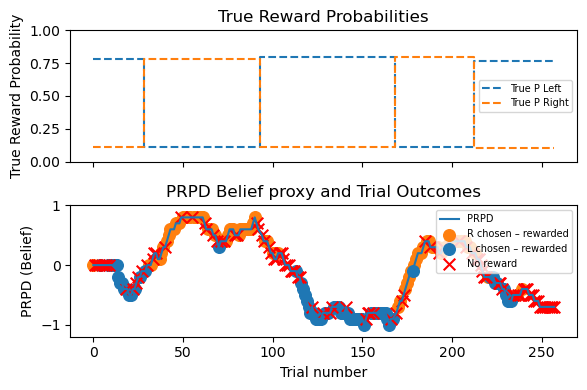

In [89]:
plt.close()
trls = trials[~trials['set reward probabs l/r'].isna()].copy()

true_prob = np.array(trls['set reward probabs l/r'].tolist())
trls['true_pL'], trls['true_pR'] = true_prob[:, 0], true_prob[:, 1]

# summary plotd
fig, (true_p_ax, prpd_ax) = plt.subplots(nrows=2, figsize=(6, 4), sharex=True)

# perceived reward probabilities (belief)
# ax.plot(trls.index, trls['PRPr'], label='PRP Right')

# true reward probabilities
true_p_ax.step(trls.index, trls['true_pL'], linestyle='--', where='mid', c='#1f77b4', label='True P Left')
true_p_ax.step(trls.index, trls['true_pR'], linestyle='--', where='mid', c='#ff7f0e', label='True P Right')
true_p_ax.set_ylabel('True Reward Probability')

true_p_ax.set_ylim(0, 1)
true_p_ax.legend(fontsize=7)
# true_p_ax.set_xticks([])

# choice outcomes
right = trls['choice'].str.lower().eq('r')
left = trls['choice'].str.lower().eq('l')

prpd_ax.plot(trls.index, trls['PRPD'], label='PRPD')

prpd_ax.scatter(trls.index[right & trls['rewarded']],
           trls.loc[right & trls['rewarded'], 'PRPD'],
           marker='o', s=70, c='#ff7f0e', label='R chosen – rewarded')
prpd_ax.scatter(trls.index[left & trls['rewarded']],
           trls.loc[left & trls['rewarded'], 'PRPD'],
           marker='o', s=70, c='#1f77b4', label='L chosen – rewarded')


prpd_ax.scatter(trls.index[ ~trls['rewarded']],
           trls.loc[~trls['rewarded'], 'PRPD'],
           marker='x', s=70, c='red', label='No reward')
# prpd_ax.scatter(trls.index[right & ~trls['rewarded']],
#            trls.loc[right & ~trls['rewarded'], 'PRPD'],
#            marker='x', s=70, c='red', label='R chosen – no reward')
# prpd_ax.scatter(trls.index[left & ~trls['rewarded']],
#            trls.loc[left & ~trls['rewarded'], 'PRPD'],
#            marker='x', s=70, c='#17becf', label='L chosen – no reward')

prpd_ax.set_xlabel('Trial number')
prpd_ax.set_ylabel('PRPD (Belief)')

true_p_ax.set_title('True Reward Probabilities')
prpd_ax.set_title('PRPD Belief proxy and Trial Outcomes')
prpd_ax.legend(fontsize=7, loc='upper right')
prpd_ax.set_ylim(-1.2, 1)
# ax.grid(alpha=0.3)
plt.tight_layout()
plt.show()

Reward/Non reward Peri-Event histograms

In [90]:
states.state.unique()

array(['delay', 'waiting', 'intertrial', 'hold', 'choosing', 'reward',
       'no reward'], dtype=object)

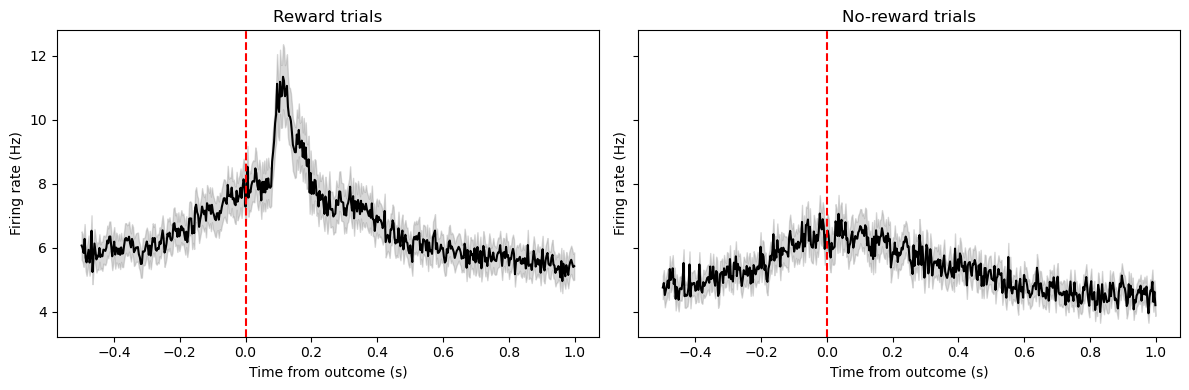

In [91]:
win = (-0.5, 1.0)
bin_ms = 3

spikes = gsp.copy()
spike_units = spikes[:, 0].astype(int)
spike_times = spikes[:, 1].astype(float)

units = np.unique(spike_units)
n_units = len(units)

# unit indices map
unit_idx = {u: np.where(spike_units == u)[0] for u in units}

# reward and no-reward event times
reward_times = (states.loc[states.state.eq('reward'), 'time'].to_numpy()).astype(float)
no_reward_times = (states.loc[states.state.eq('no reward'), 'time'].to_numpy()).astype(float)

# convert window and bins to milliseconds
pre_ms = win[0] * 1000
post_ms = win[1] * 1000
bin_edges = np.arange(pre_ms, post_ms + bin_ms, bin_ms)
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2 / 1000

# PSTH for a set of event times
def compute_psth(event_times_ms):
    '''
    Returns array shape (n_units, n_bins) with trial-averaged firing rate (Hz).
    Assumes spike_times and event_times_ms are in milliseconds.
    '''
    n_bins = len(bin_edges) - 1
    psth = np.zeros((n_units, n_bins))

    for ui, u in enumerate(units):
        st = spike_times[unit_idx[u]]

        cut = np.concatenate([
            st[(st >= t + pre_ms) & (st < t + post_ms)] - t
            for t in event_times_ms
        ])
        if cut.size:
            counts, _ = np.histogram(cut, bins=bin_edges)
            psth[ui] = counts / (len(event_times_ms) * (bin_ms / 1000))
    return psth

# PSTHs
psth_reward = compute_psth(reward_times)
psth_no_reward = compute_psth(no_reward_times)

fig, axs = plt.subplots(1, 2, figsize=(12, 4), sharey=True)

for ax, psth, title in zip(
        axs,
        [psth_reward, psth_no_reward],
        ['Reward trials', 'No-reward trials']):

    mean_rate = psth.mean(axis=0)
    sem_rate = psth.std(axis=0) / np.sqrt(n_units)

    ax.plot(bin_centers, mean_rate, color='k')
    ax.fill_between(bin_centers, mean_rate - sem_rate, mean_rate + sem_rate,
                    color='gray', alpha=0.3)
    ax.axvline(0, ls='--', color='red')
    ax.set_title(title)
    ax.set_xlabel('Time from outcome (s)')
    ax.set_ylabel('Firing rate (Hz)')

plt.tight_layout()
plt.show()


Spike Preprocessing

Binning to 10ms firing rate

In [92]:
wheel_ms = wheel[:,0]
wheel_pos = angles

In [93]:
spikes[:,1]

array([ 376224.10628445,  376225.51808359,  376225.6038248 , ...,
       1776170.63039667, 1776170.84103566, 1776172.08101087],
      shape=(3253121,))

In [94]:
BIN_MS = 10
BIN_S = BIN_MS / 1000


spike_df = (
    pd.DataFrame(spikes, columns=['unit', 'sample'])
      .astype({'unit': 'int32', 'sample': 'float64'})
)
# spike_df['time_ms'] = spike_df['sample'] / SR * 1_000
spike_df['time_ms'] = spike_df['sample']

units = np.sort(spike_df['unit'].unique())
u2i = {u: i for i, u in enumerate(units)}
nU = len(units)


trials_sorted = (trials
                 .sort_values('start')
                 .drop_duplicates(subset='start')
                 .reset_index(drop=True))
t_start = trials_sorted['start'].values
t_end = np.append(t_start[1:], spike_df['time_ms'].max())

# --binning loop --------------------
trial_bins, bin_edges = [], []
spike_bins_map, bin_edges_map = {}, {}
wheel_t_map, wheel_pos_map = {}, {}

for t0, t1 in zip(t_start, t_end):
    if t1 - t0 < BIN_MS:
        trial_bins.append(np.zeros((nU, 0), dtype=np.uint16))
        bin_edges.append(np.array([t0, t1]))
        continue

    edges = np.arange(t0, t1 + BIN_MS, BIN_MS, dtype=np.float64)
    n_bins = len(edges) - 1

    M = np.zeros((nU, n_bins), dtype=np.uint16)

    msk = (spike_df['time_ms'] >= t0) & (spike_df['time_ms'] < t1)
    sub = spike_df.loc[msk]

    if not sub.empty:
        bin_idx = ((sub['time_ms'] - t0) // BIN_MS).astype(int).values
        unit_idx = sub['unit'].map(u2i).values
        np.add.at(M, (unit_idx, bin_idx), 1)

    trial_bins.append(M)
    bin_edges.append(edges)
    spike_bins_map[t0] = M
    bin_edges_map[t0] = edges
    
    # wheel to trial
    wmask = (wheel_ms >= t0) & (wheel_ms < t1)
    wheel_t_map[t0]= (wheel_ms[wmask] - t0).astype(np.float32)
    wheel_pos_map[t0]= wheel_pos[wmask].astype(np.float32)

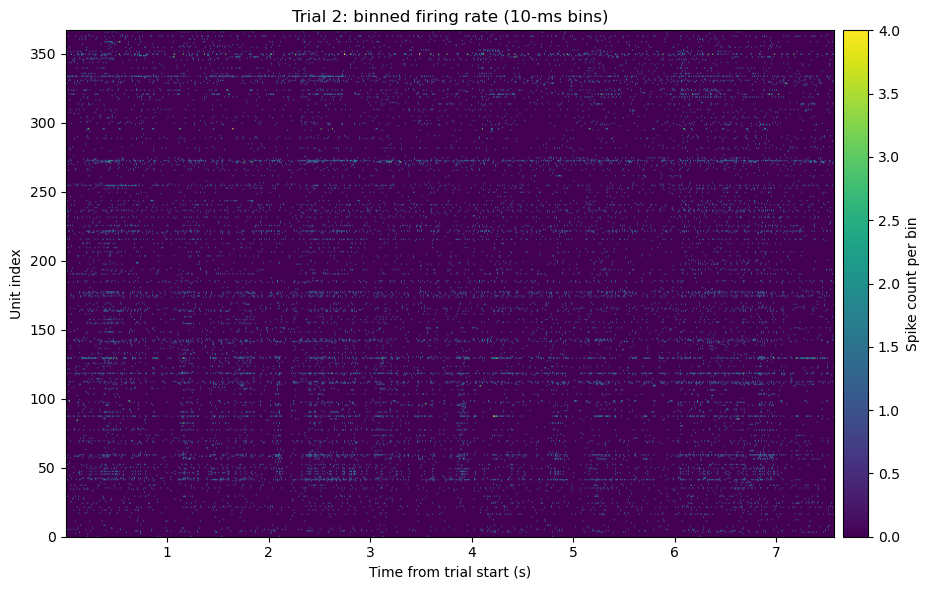

In [95]:
trial_idx = 1 
M = trial_bins[trial_idx]
edges = bin_edges[trial_idx]
centers_ms = (edges[:-1] + edges[1:]) / 2
t_rel_s = (centers_ms - edges[0]) / 1000

fig, ax = plt.subplots(figsize=(10, 6))

im = ax.imshow(M, aspect='auto', cmap='viridis',
               extent=[t_rel_s[0], t_rel_s[-1], 0, M.shape[0]],
               origin='lower')

ax.set_xlabel('Time from trial start (s)')
ax.set_ylabel('Unit index')
ax.set_title(f'Trial {trial_idx+1}: binned firing rate ({BIN_MS}-ms bins)')
cbar = plt.colorbar(im, ax=ax, pad=0.01)
cbar.set_label('Spike count per bin')

plt.tight_layout()
plt.show()


States vs Spike scatterplot vs wheel position

In [96]:
trials[:10]

,start,hold_start,t choosing,t chosen,choice,rewarded,set reward probabs l/r,Achievement reached,reward rate recent,rew rate in recent rights,rew rate in recent lefts,PRPr,PRPl,PRPD,RR_rate
0,483046,483964.0,484765.0,485080.0,r,True,"[0.7837631053618482, 0.11006217680373397]",False,1.000000,1.000000,0.000000,0.5,0.5,0.0,0.5
1,486080,487305.0,488275.0,488649.0,r,False,"[0.7837631053618482, 0.11006217680373397]",False,0.500000,0.500000,0.000000,0.5,0.5,0.0,0.5
2,493650,494603.0,495854.0,495982.0,r,False,"[0.7837631053618482, 0.11006217680373397]",False,0.333333,0.333333,0.000000,0.5,0.5,0.0,0.5
3,500981,502049.0,503589.0,504336.0,l,False,"[0.7837631053618482, 0.11006217680373397]",False,0.250000,0.333333,0.000000,0.5,0.5,0.0,0.5
4,509336,510282.0,511612.0,512170.0,l,True,"[0.7837631053618482, 0.11006217680373397]",False,0.400000,0.333333,0.500000,0.5,0.5,0.0,0.5
5,513170,514487.0,515698.0,515840.0,l,False,"[0.7837631053618482, 0.11006217680373397]",False,0.333333,0.333333,0.333333,0.5,0.5,0.0,0.5
6,520839,522377.0,523508.0,524581.0,r,False,"[0.7837631053618482, 0.11006217680373397]",False,0.285714,0.250000,0.333333,0.5,0.5,0.0,0.5
7,529581,530747.0,531838.0,532296.0,r,False,"[0.7837631053618482, 0.11006217680373397]",False,0.250000,0.200000,0.333333,0.5,0.5,0.0,0.5
8,537297,538797.0,539858.0,540169.0,l,True,"[0.7837631053618482, 0.11006217680373397]",False,0.333333,0.200000,0.500000,0.5,0.5,0.0,0.5
9,541170,542723.0,543523.0,543673.0,l,False,"[0.7837631053618482, 0.11006217680373397]",False,0.300000,0.200000,0.400000,0.5,0.5,0.0,0.5


In [97]:
states[states.state == 'intertrial']

,time,state
10,483046,intertrial
14,486080,intertrial
18,493650,intertrial
22,500981,intertrial
26,509336,intertrial
...,...,...
1010,1869729,intertrial
1014,1876942,intertrial
1018,1884284,intertrial
1022,1891608,intertrial


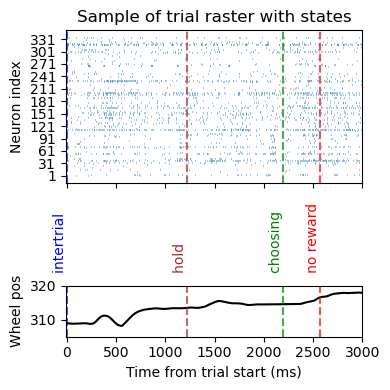

In [98]:

t0_ms = trials['start'].iloc[1]
t1_ms = trials['start'].iloc[2]

# t0_samp, t1_samp = (int(t0_ms * SR / 1_000), int(t1_ms * SR / 1_000))
t0_samp, t1_samp = (int(t0_ms), int(t1_ms))

in_win = (spikes[:, 1] >= t0_samp) & (spikes[:, 1] < t1_samp)
spw = spikes[in_win]
units = np.sort(np.unique(spw[:, 0]).astype(int))
u2i = {u: i for i, u in enumerate(units)}

# rel_t_ms = (spw[:, 1] - t0_samp) / SR * 1_000
rel_t_ms = (spw[:, 1] - t0_samp)
rel_u = np.vectorize(u2i.get)(spw[:, 0])

# wheel trace 
wheel_mask = (wheel_ms >= t0_ms) & (wheel_ms < t1_ms)
wheel_t_rel = wheel_ms[wheel_mask] - t0_ms
wheel_pos_rel = wheel_pos[wheel_mask]

# state lines 
states['time_ms'] = states['time']

state_rows = states[(states['time_ms'] >= t0_ms) & (states['time_ms'] < t1_ms)]
state_times_rel = state_rows['time_ms'] - t0_ms

state_colors = {
    'delay': 'gray',
    'waiting': 'orange',
    'intertrial': 'blue',
    'hold': 'brown',
    'choosing': 'green',
    'reward': 'lightgray',
    'no reward': 'red'
}

fig, (ax_raster, ax_wheel) = plt.subplots(
    2, 1, figsize=(4, 4), sharex=True,
    gridspec_kw=dict(height_ratios=[3, 1])
)

for u_idx, u in enumerate(units):
    ax_raster.vlines(rel_t_ms[rel_u == u_idx], u_idx + .6, u_idx + 1.4, lw=0.6)

ax_raster.set_yticks(np.arange(1, len(units) + 1)[::30])
# ax_raster.set_yticklabels(units[::15])
ax_raster.set_ylabel('Neuron index')
ax_raster.set_title('Sample of trial raster with states')

# wheel trace
ax_wheel.plot(wheel_t_rel, wheel_pos_rel, color='k')
ax_wheel.set_xlabel('Time from trial start (ms)')
ax_wheel.set_ylabel('Wheel pos')
ax_wheel.set_ylim((305, 320))

# vertical states lines 
for t_rel, state in zip(state_times_rel, state_rows['state']):
    ax_raster.axvline(t_rel, color=state_colors.get(state, 'k'), ls='--', alpha=.7)
    ax_wheel.axvline(t_rel, color=state_colors.get(state, 'k'), ls='--', alpha=.7)
    ax_wheel.text(t_rel, ax_wheel.get_ylim()[1], f'   {state}',
                  rotation=90, va='bottom', ha='right', fontsize=10, color=state_colors.get(state,'k'))
plt.xlim((-10,3000))
plt.tight_layout()
plt.show()


Trials dataset for modeling:

In [99]:
trials['bin_ms'] = BIN_MS
trials['spike_bins'] = trials['start'].map(spike_bins_map)
trials['bin_edges_ms'] = trials['start'].map(bin_edges_map)
trials['wheel_t_ms'] = trials['start'].map(wheel_t_map)
trials['wheel_pos'] = trials['start'].map(wheel_pos_map)

In [100]:
quality_df = pd.read_csv(droot/'PHY_AK/quality_metrics.csv')

shape mismatch:

In [101]:
quality_df.shape, clust_qa.shape

((605, 51), (575, 2))

In [102]:
clust_qa.cluster_id.max(), quality_df.unit_id.max()

(np.int64(648), np.int64(604))

In [103]:
quality_df.groupby('KS_label').count()

,Unnamed: 0,unit_id,num_spikes,firing_rate,presence_ratio,snr,isi_violations_ratio,isi_violations_count,rp_contamination,rp_violations,...,noise_probability_si_ur_nnc,mua_probability_si_ur_smc,mua_probability_aj3_smcl,noise_probability_aj3_nncl,SI_temp_duration_ms,SI_temp_spatial_decay_uV_um,KS_wavef_duration_ms,KS_wavef_spatial_decay_uV_um,KS_temp_duration_ms,KS_temp_spatial_decay_uV_um
KS_label,,,,,,,,,,,,,,,,,,,,,
good,461,461,461,461,461,461,461,461,461,461,...,461,461,461,461,461,461,461,146,461,146
mua,144,144,144,144,144,144,144,144,144,144,...,144,144,144,144,140,144,144,100,144,100


spikes was manually curated but quality_metrics was computed for raw spike-sorting

Inter-trial intervals for training are better for PRPD prediction as it may contain less movement noise.

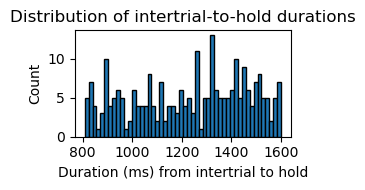

In [104]:
df = states.copy().sort_values('time_ms').reset_index(drop=True)

inter_idxs = df.index[df['state'] == 'intertrial'].to_numpy()
hold_idxs = df.index[df['state'] == 'hold'].to_numpy()

durations = []
intervals = []

for i in inter_idxs:
    future_holds = hold_idxs[hold_idxs > i]
    if future_holds.size == 0:
        continue
    j = future_holds[0]
    t0 = df.at[i, 'time_ms']
    t1 = df.at[j, 'time_ms']
    dt = t1 - t0

    durations.append(dt)
    intervals.append((t0, t1))

durations = np.array(durations)
intervals = np.array(intervals)

plt.figure(figsize=(3, 2))
plt.hist(durations, bins=50, edgecolor='k')
plt.xlabel('Duration (ms) from intertrial to hold')
plt.ylabel('Count')
plt.title('Distribution of intertrial-to-hold durations')
plt.tight_layout()
plt.show()

Lowest ITI period is 800ms window.
We take this as a constant period for further dataset cration.
Now we find the 800 window for each trial with smallest avg wheel speed to reduce movement noise further.

In [105]:
ITI_WIN = 800

# interpolate pos at uniform 1 kHz grid
t_start, t_end = wheel_ms.min(), wheel_ms.max()
time_grid = np.arange(t_start, t_end + 1)# every ms

pos_interp = np.interp(time_grid, wheel_ms, wheel_pos)

# wheel speed
speed = np.abs(np.gradient(pos_interp, 1) * 1000.0)
# convolution to get mean‐speed at each ms
avg_speed = np.convolve(speed, np.ones(ITI_WIN)/ITI_WIN, mode='valid')

window_starts = time_grid[:len(avg_speed)]

# for each ITI pick the slowest 800ms window
results = []
for (t0, t1) in intervals:
    # valid window-starts are fully contained in [t0,t1]
    valid = np.where(
        (window_starts >= t0) &
        (window_starts + ITI_WIN - 1 <= t1)
    )[0]
    if valid.size == 0:
        continue
    best_idx = valid[np.argmin(avg_speed[valid])]
    results.append({
        'iti_start': t0,
        'iti_end': t1,
        'win_start': window_starts[best_idx],
        'win_end': window_starts[best_idx] + ITI_WIN - 1,
        'mean_speed': avg_speed[best_idx]
    })

slowest_windows = pd.DataFrame(results)
print(f'Found {len(slowest_windows)} slowest windows (800 ms each)')

Found 258 slowest windows (800 ms each)


In [106]:
slowest_windows

,iti_start,iti_end,win_start,win_end,mean_speed
0,483046,483964,483046,483845,9.334147
1,486080,487305,486506,487305,10.495495
2,493650,494603,493804,494603,4.586913
3,500981,502049,500981,501780,0.970645
4,509336,510282,509483,510282,0.616371
...,...,...,...,...,...
253,1869729,1870764,1869729,1870528,7.437176
254,1876942,1878125,1877326,1878125,5.215819
255,1884284,1885352,1884284,1885083,0.014611
256,1891608,1893101,1891782,1892581,0.139125


Now we cut spikes corresponding to the ITI windows we selected.
We use offset BEHAV_LAG_MS=200ms to align mPFC activety to slowest weel speed ITI windows.

In [107]:
iti_periods = np.array([[r.win_start, r.win_end] for _,r in slowest_windows.iterrows()])

In [108]:
BEHAV_LAG_MS = 200 # mPFC activety predicate behaviour response with lag of about 75-300ms
BIN_MS = 10

units = np.sort(spike_df['unit'].unique())
unit2col = {u: i for i, u in enumerate(units)}
n_units = len(units)

T = int(np.ceil(ITI_WIN/ BIN_MS))
n_trials = len(iti_periods)

spike_tensor = np.zeros((n_trials, T, n_units), dtype=np.uint8)

for i, (t_start_ms, t_end_ms) in enumerate(iti_periods):
    # align spikes to behaviour clock
    t_start_ms -= BEHAV_LAG_MS
    t_end_ms -= BEHAV_LAG_MS

    m = (spike_df.time_ms.values >= t_start_ms) & \
                  (spike_df.time_ms.values <  t_end_ms)
    sub = spike_df.loc[m]

    if sub.empty: continue

    bin_idx = ((sub.time_ms.values - t_start_ms) // BIN_MS).astype(np.int64)
    unit_idx = sub.unit.map(unit2col).values.astype(np.int64)
    np.add.at(spike_tensor, (i, bin_idx, unit_idx), 1)

The spikes has recording duration smaller than behaviour, hence we have 0 trials, filter them:

In [109]:
no_spikes = spike_tensor.max(axis=(1,2))==0
no_spikes_trials = np.argwhere(no_spikes)
no_spikes_trials[[0,-1]]


array([[241],
       [257]])

In [110]:
spikes_to_store = spike_tensor[~no_spikes, :, :]
spikes_to_store.shape

(241, 80, 367)

Check last ITI have full window spikes

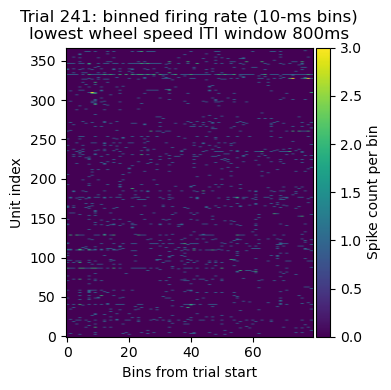

In [111]:
# plot binned firing rate heat-map
fig, ax = plt.subplots(figsize=(4, 4))

im = ax.imshow(spikes_to_store[-1].T, aspect='auto', cmap='viridis', origin='lower')

ax.set_xlabel('Bins from trial start')
ax.set_ylabel('Unit index')
ax.set_title(f'Trial {spikes_to_store.shape[0]}: binned firing rate ({BIN_MS}-ms bins)\nlowest wheel speed ITI window {ITI_WIN}ms')
cbar = plt.colorbar(im, ax=ax, pad=0.01)
cbar.set_label('Spike count per bin')

plt.tight_layout()
plt.show()

In [112]:
trials_to_store = trials[:spikes_to_store.shape[0]]
trials_to_store.shape, spikes_to_store.shape

((241, 20), (241, 80, 367))

Store dataset for training:

In [113]:
trials_to_store.PRPD.values

array([ 0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,
        0. ,  0. ,  0. , -0.2, -0.3, -0.3, -0.4, -0.4, -0.4, -0.5, -0.5,
       -0.4, -0.4, -0.3, -0.2, -0.2, -0.1, -0.1, -0.1,  0. ,  0. ,  0. ,
        0.1,  0.2,  0.2,  0.1,  0.1,  0.2,  0.3,  0.3,  0.4,  0.5,  0.6,
        0.6,  0.6,  0.7,  0.7,  0.7,  0.8,  0.8,  0.8,  0.8,  0.8,  0.8,
        0.8,  0.8,  0.8,  0.8,  0.8,  0.8,  0.8,  0.7,  0.6,  0.6,  0.6,
        0.6,  0.5,  0.5,  0.4,  0.3,  0.4,  0.4,  0.4,  0.4,  0.5,  0.6,
        0.6,  0.6,  0.5,  0.5,  0.5,  0.6,  0.6,  0.6,  0.6,  0.6,  0.6,
        0.6,  0.7,  0.8,  0.7,  0.6,  0.6,  0.5,  0.4,  0.4,  0.4,  0.3,
        0.2,  0.2,  0.1,  0.1,  0.2,  0.2,  0.2,  0.1,  0. ,  0. ,  0. ,
       -0.1, -0.1, -0.1, -0.1, -0.2, -0.2, -0.3, -0.4, -0.5, -0.6, -0.7,
       -0.8, -0.7, -0.8, -0.9, -0.9, -0.9, -0.9, -0.8, -0.8, -0.8, -0.8,
       -0.8, -0.7, -0.7, -0.7, -0.7, -0.7, -0.8, -0.8, -0.8, -0.7, -0.8,
       -0.9, -0.9, -0.9, -0.9, -0.9, -0.9, -0.9, -0

In [114]:
# normalize spikes
print(f'normalizer: {spikes_to_store.max()}')
spikes_to_store = spikes_to_store.astype(np.float32)
spikes_to_store /= spikes_to_store.max()

normalizer: 5


In [115]:
# store trial-by-trial spikes and flags
processed_folder = Path('C:/Users/qf1824/Desktop/coding/Arseniis_Msc_proj/data/processed')
# save spikes
np.savez(processed_folder / 'spikes.npz', spikes_to_store)
# save labels
np.savez(processed_folder / 'prpd.npz', trials_to_store.PRPD.values)
# splits for reproducibility
trials_to_store.to_json(processed_folder / 'trials.pkl')

SPLITS_SEED = 362864
n_trials = spikes_to_store.shape[0]

perm = np.random.RandomState(seed=SPLITS_SEED).permutation(n_trials)
n_train = int(0.7 * n_trials)
n_val = int(0.15 * n_trials)

splits = {
    'train': perm[:n_train].tolist(),
    'val': perm[n_train:n_train + n_val].tolist(),
    'test': perm[n_train + n_val:].tolist(),
}

with open(processed_folder/'splits.json', 'w') as f:
    json.dump(splits, f, indent=2)

In [116]:
spike_df.to_csv(processed_folder / 'spikes_df_full.csv')

In [117]:
np.load(processed_folder / 'prpd.npz')['arr_0']

array([ 0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,
        0. ,  0. ,  0. , -0.2, -0.3, -0.3, -0.4, -0.4, -0.4, -0.5, -0.5,
       -0.4, -0.4, -0.3, -0.2, -0.2, -0.1, -0.1, -0.1,  0. ,  0. ,  0. ,
        0.1,  0.2,  0.2,  0.1,  0.1,  0.2,  0.3,  0.3,  0.4,  0.5,  0.6,
        0.6,  0.6,  0.7,  0.7,  0.7,  0.8,  0.8,  0.8,  0.8,  0.8,  0.8,
        0.8,  0.8,  0.8,  0.8,  0.8,  0.8,  0.8,  0.7,  0.6,  0.6,  0.6,
        0.6,  0.5,  0.5,  0.4,  0.3,  0.4,  0.4,  0.4,  0.4,  0.5,  0.6,
        0.6,  0.6,  0.5,  0.5,  0.5,  0.6,  0.6,  0.6,  0.6,  0.6,  0.6,
        0.6,  0.7,  0.8,  0.7,  0.6,  0.6,  0.5,  0.4,  0.4,  0.4,  0.3,
        0.2,  0.2,  0.1,  0.1,  0.2,  0.2,  0.2,  0.1,  0. ,  0. ,  0. ,
       -0.1, -0.1, -0.1, -0.1, -0.2, -0.2, -0.3, -0.4, -0.5, -0.6, -0.7,
       -0.8, -0.7, -0.8, -0.9, -0.9, -0.9, -0.9, -0.8, -0.8, -0.8, -0.8,
       -0.8, -0.7, -0.7, -0.7, -0.7, -0.7, -0.8, -0.8, -0.8, -0.7, -0.8,
       -0.9, -0.9, -0.9, -0.9, -0.9, -0.9, -0.9, -0

Find non-zero correlates neurons to PRPD using avg firing rate

Using simple Lasso regression

In [118]:
X = spikes_to_store.mean(axis=1)[:-1]
y = trials_to_store.PRPD.values[1:]

X_scaled = StandardScaler().fit_transform(X)
lasso = LassoCV(cv=5, random_state=0).fit(X_scaled, y)

# important neurons
coefs = lasso.coef_
important_idx = np.where(coefs != 0)[0]# non-zero weights
num_important = important_idx.size

print(f'Single-cell encoding: {num_important} / {X.shape[1]} is {100*num_important/X.shape[1]:.1f}% neurons')
print('Neuron indices:', important_idx)

Single-cell encoding: 143 / 367 is 39.0% neurons
Neuron indices: [  0   2   4  11  12  14  15  18  19  25  30  36  39  41  48  52  58  62
  63  64  67  70  71  73  74  75  76  78  79  86  89  91  93  96 101 103
 105 106 108 116 117 119 120 124 126 127 132 135 137 138 141 143 145 146
 149 150 153 154 155 157 160 161 163 164 165 167 169 172 175 183 186 188
 195 196 197 198 199 201 202 204 205 207 213 217 219 222 223 224 230 231
 233 234 235 239 245 247 254 256 258 259 260 261 263 269 270 282 289 292
 295 297 300 309 311 313 314 315 321 322 323 324 325 326 327 334 337 338
 344 345 346 348 349 350 351 352 353 354 356 357 358 360 361 363 366]


Using linear least-squares regression

In [119]:

sig_neurons = []
for i in range(X_scaled.shape[1]):
    slope, intercept, r_value, p_value, stderr = linregress(y, X_scaled[:, i])
    if p_value < 0.05:
        sig_neurons.append(i)
print(f'Single-cell encoding: {len(sig_neurons)} / {X.shape[1]} is {100*len(sig_neurons)/X.shape[1]:.1f}% neurons')
print('neuron indices:', sig_neurons)

Single-cell encoding: 131 / 367 is 35.7% neurons
neuron indices: [4, 5, 11, 14, 21, 22, 36, 38, 39, 41, 43, 47, 48, 49, 51, 52, 59, 62, 64, 69, 70, 74, 78, 83, 87, 93, 96, 97, 103, 112, 113, 114, 115, 124, 125, 126, 131, 132, 135, 138, 143, 153, 154, 157, 159, 160, 161, 164, 165, 166, 167, 168, 174, 177, 182, 183, 187, 193, 205, 208, 209, 211, 213, 215, 217, 219, 220, 221, 224, 227, 230, 232, 236, 238, 239, 242, 243, 244, 246, 247, 248, 252, 255, 256, 257, 259, 260, 264, 265, 266, 270, 276, 279, 281, 282, 285, 293, 295, 298, 303, 304, 307, 313, 315, 317, 321, 323, 324, 326, 327, 332, 333, 335, 337, 338, 339, 340, 341, 343, 344, 345, 346, 347, 348, 349, 353, 354, 359, 362, 363, 366]


In [120]:
pipe = make_pipeline(
        StandardScaler(with_mean=True),
        Ridge(alpha=1.0)
)

cv = KFold(n_splits=10, shuffle=True, random_state=0)
r2 = cross_val_score(pipe, X, y, cv=cv, scoring='r2').mean()
print(f'Z-scored R2 = {r2:.2f}')

Z-scored R2 = 0.46


In [121]:
alphas = 10.0 ** np.arange(-2, 3)
model = make_pipeline(StandardScaler(),
                       RidgeCV(alphas=alphas, cv=cv, scoring='r2'))
r2_opt = cross_val_score(model, X, y, cv=cv, scoring='r2').mean()

r2_opt

np.float64(0.7318500808698614)

No leak verification

In [122]:
inner = KFold(n_splits=5, shuffle=True, random_state=0)
ridge = RidgeCV(alphas=10.0**np.arange(-2,3), cv=inner, scoring='r2')

pipe = Pipeline([
    ('scale', StandardScaler(with_mean=True)),
    ('ridge', ridge)
])

outer = KFold(n_splits=10, shuffle=True, random_state=1)
r2 = cross_val_score(pipe, X, y, cv=outer, scoring='r2')
print(f'Nested-CV R2 = {r2.mean():.3f} +- {r2.std():.3f}')


Nested-CV R2 = 0.730 +- 0.099


In [123]:
r2_shuff = cross_val_score(pipe, X, shuffle(y, random_state=42),
                           cv=outer, scoring='r2').mean()
print(f'Shuffled-label R2 = {r2_shuff:.3f}')

Shuffled-label R2 = -0.491


In [124]:
split_idx = int(0.67 * len(y))
X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]

pipe.fit(X_train, y_train)
print('Forward-prediction R2 =', pipe.score(X_test, y_test))

Forward-prediction R2 = -0.6279359039037633


Text(0.5, 1.0, 'Inter-trial firing-rate distribution\n(367 mPFC neurons, 241 trials)')

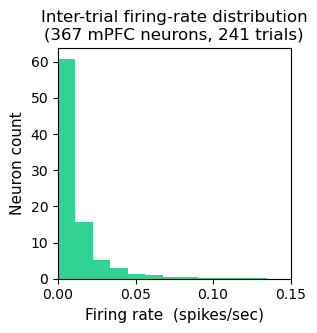

In [125]:
fr = X.flatten()

plt.figure(figsize=(3, 3))
plt.hist(fr, bins=30, density=True,
         alpha=0.8, color='#00c97cff')
plt.xlabel('Firing rate  (spikes/sec)', fontsize=11)
plt.ylabel('Neuron count', fontsize=11)
plt.xlim(0,0.15)
plt.title('Inter-trial firing-rate distribution\n(367 mPFC neurons, 241 trials)', fontsize=12)


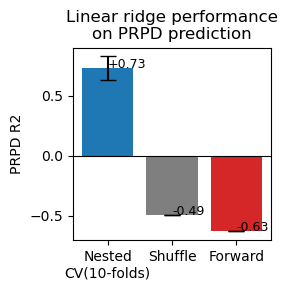

In [126]:
inner = KFold(n_splits=5, shuffle=True,  random_state=0)
outer = KFold(n_splits=10, shuffle=True, random_state=1)

ridge = RidgeCV(alphas=10.0**np.arange(-2, 3), cv=inner, scoring='r2')
pipe = Pipeline([('scale', StandardScaler()), ('ridge', ridge)])

outer_scores = cross_val_score(pipe, X, y, cv=outer, scoring='r2')
nested_mean, nested_std = outer_scores.mean(), outer_scores.std()

shuffle_mean = cross_val_score(pipe, X, shuffle(y, random_state=42),
                               cv=outer, scoring='r2').mean()

split = int(0.67 * len(y))
pipe.fit(X[:split], y[:split])
forward_mean = pipe.score(X[split:], y[split:])

labels = ['Nested\nCV(10-folds)', 'Shuffle', 'Forward']
vals = [nested_mean, shuffle_mean, forward_mean]
errs = [nested_std, 0, 0]

fig, ax = plt.subplots(figsize=(3, 3))
bars = ax.bar(labels, vals, yerr=errs, capsize=6,
              color=['tab:blue', 'tab:gray', 'tab:red'])

ax.axhline(0, color='k', linewidth=0.8)
ax.set_ylabel('PRPD R2')
ax.set_title('Linear ridge performance\non PRPD prediction')

for bar, v in zip(bars, vals):
    ax.text(bar.get_x() + bar.get_width()/2, v + 0.03,
            f'{v:+.2f}', ha='left', va='center', fontsize=9)

plt.tight_layout()
plt.show()



86 / 367 neurons significant (23%)


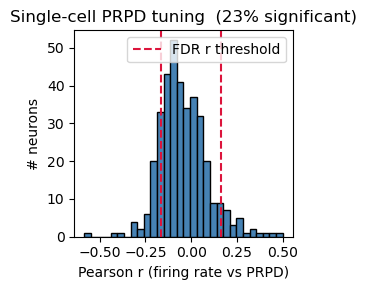

In [127]:
r_vals, p_vals = [], []

for j in range(X.shape[1]):
    r, p = pearsonr(y, X[:, j])
    r_vals.append(r)
    p_vals.append(p)

r_vals = np.array(r_vals)
p_vals = np.array(p_vals)

rej, q_vals, *_ = multipletests(p_vals, alpha=0.05, method='fdr_bh')
sig_idx = np.where(rej)[0]
frac_sig = len(sig_idx) / X.shape[1]

print(f'{len(sig_idx)} / {X.shape[1]} neurons significant '
      f'({frac_sig:.0%})')

plt.figure(figsize=(3,3))
# plt.hist(r_vals, bins=30, color='steelblue', alpha=0.8, edgecolor='k')
# plt.axvline(0, color='k', lw=0.8)
# plt.axvline(r_vals[sig_idx].min(), color='crimson', ls='--', label='FDR threshold')
plt.xlabel('Pearson r (firing rate vs PRPD)')
crit = np.abs(r_vals[sig_idx]).min()
plt.hist(r_vals, bins=30, color='steelblue', edgecolor='k')
plt.axvline(-crit, color='crimson', ls='--', label='FDR r threshold')
plt.axvline(+crit, color='crimson', ls='--')
plt.ylabel('# neurons')
plt.title(f'Single-cell PRPD tuning  ({frac_sig:.0%} significant)')
plt.legend()
plt.tight_layout()
plt.show()



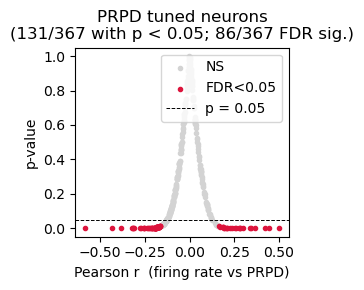

In [128]:
logp = -np.log10(p_vals)
sig = rej

plt.figure(figsize=(3,3))
# plt.scatter(r_vals[~sig], logp[~sig],  s=18, c='lightgrey', label='NS')
# plt.scatter(r_vals[sig] , logp[sig] ,  s=18, c='crimson' , label='FDR<0.05')
plt.scatter(r_vals[~sig], p_vals[~sig],  s=9, c='lightgrey', label='NS')
plt.scatter(r_vals[sig] , p_vals[sig] ,  s=9, c='crimson' , label='FDR<0.05')

# crit_r = np.abs(r_vals[sig]).min()
# crit_logp= -np.log10(0.05 * len(p_vals) / np.arange(1,len(p_vals)+1)[sig][0])

# plt.axvline(+crit_r, color='k', ls='--', lw=0.7)
# plt.axvline(-crit_r, color='k', ls='--', lw=0.7)
# plt.axhline(crit_logp, color='k', ls='--', lw=0.7)
plt.axhline(0.05, color='k', ls='--', lw=0.7, label='p = 0.05')

plt.xlabel('Pearson r  (firing rate vs PRPD)')
plt.ylabel('p-value')
plt.title(f'PRPD tuned neurons\n({np.sum(p_vals<0.05)}/{len(sig)} with p < 0.05; {sig.sum()}/{len(sig)} FDR sig.)')
plt.legend()
# plt.legend(frameon=False)
plt.tight_layout();  plt.show()


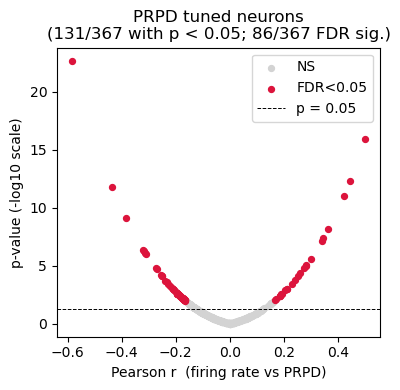

In [129]:

logp = -np.log10(p_vals)
sig = rej

plt.figure(figsize=(4,4))
plt.scatter(r_vals[~sig], logp[~sig], s=18, c='lightgrey', label='NS')
plt.scatter(r_vals[sig] , logp[sig] , s=18, c='crimson' , label='FDR<0.05')
# plt.scatter(r_vals[~sig], p_vals[~sig], s=9, c='lightgrey', label='NS')
# plt.scatter(r_vals[sig] , p_vals[sig] , s=9, c='crimson' , label='FDR<0.05')

crit_r = np.abs(r_vals[sig]).min()
crit_logp= -np.log10(0.05 * len(p_vals) / np.arange(1,len(p_vals)+1)[sig][0])

# plt.axvline(+crit_r, color='k', ls='', lw=0.7)
# plt.axvline(-crit_r, color='k', ls='--', lw=0.7)
# plt.axhline(crit_logp, color='k', ls='--', lw=0.7)
plt.axhline(-np.log10(0.05), color='k', ls='--', lw=0.7, label='p = 0.05')

plt.xlabel('Pearson r  (firing rate vs PRPD)')
plt.ylabel('p-value (-log10 scale)')
plt.title(f'PRPD tuned neurons\n({np.sum(p_vals<0.05)}/{len(sig)} with p < 0.05; {sig.sum()}/{len(sig)} FDR sig.)')
plt.legend()
# plt.legend(frameon=False)
plt.tight_layout();  plt.show()


In [130]:
np.sum(p_vals<0.05)

np.int64(131)

c:\Users\qf1824\AppData\Local\miniconda3\envs\stremb\Lib\site-packages\numpy\lib\_histograms_impl.py:901: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges


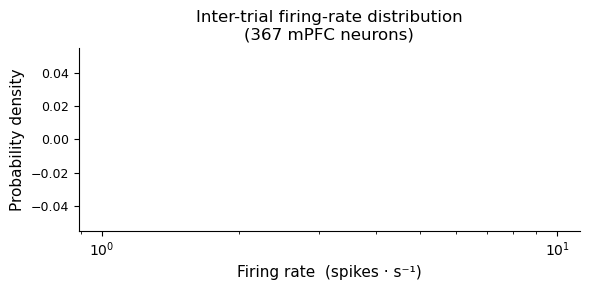

In [131]:
fr = X

bins = np.geomspace(1e-2,
                    fr.max() + 0.5,
                    40)

plt.figure(figsize=(6, 3))
sns.histplot(fr.flatten(), bins=bins,
             color='#00c97cff', edgecolor='none', log_scale=True,
             stat='density')

# plt.xscale('log')
plt.xlabel('Firing rate  (spikes · s⁻¹)', fontsize=11)
plt.ylabel('Probability density', fontsize=11)
plt.title('Inter-trial firing-rate distribution\n(367 mPFC neurons)', fontsize=12)
plt.yticks(fontsize=9)
# plt.xticks([0.01, 0.1, 1, 10], ['0.01', '0.1', '1', '10 Hz'], fontsize=9)

# med = np.median(fr)
# plt.axvline(med, ls='--', lw=1, color='grey')
# plt.text(med*1.1, plt.ylim()[1]*0.8,
#          f'median = {med:.2f} Hz', fontsize=9, color='grey')

sns.despine()
plt.tight_layout()
plt.show()


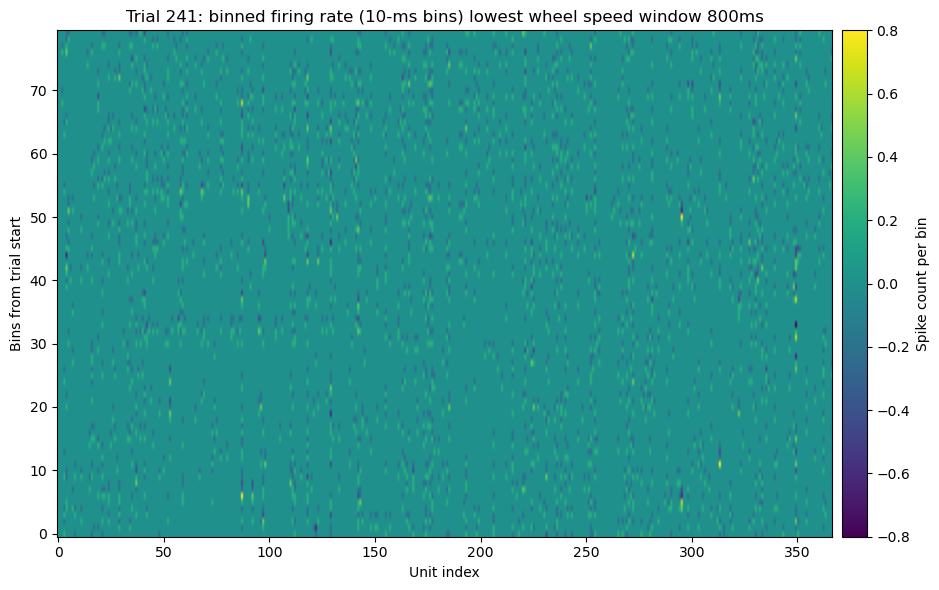

In [132]:
spike_diff = np.load(processed_folder / 'spikes.npz')['arr_0'] - np.load(processed_folder / 'spikes_old.npz')['arr_0']

fig, ax = plt.subplots(figsize=(10, 6))

im = ax.imshow(spike_diff[0], aspect='auto', cmap='viridis', origin='lower')

ax.set_ylabel('Bins from trial start')
ax.set_xlabel('Unit index')
ax.set_title(f'Trial {spikes_to_store.shape[0]}: binned firing rate ({BIN_MS}-ms bins) lowest wheel speed window {ITI_WIN}ms')
cbar = plt.colorbar(im, ax=ax, pad=0.01)
cbar.set_label('Spike count per bin')

plt.tight_layout()
plt.show()